#### 이 코드는 아래와 같은 환경에서 수행되었습니다. 

VM : google cloud platform compute Engine VM instance

cpu : e2-highmen-8(8core)

Ram : 64gb

hdd : 500gb

# 학습 데이터 생성 및 전처리 코드

- 선택과 집중(공유된코드와 동일) :  가장 먼저, Pubchem에서 5000만 개의 분자식을 불러온 후 분자식의 캐릭터 빈도수를 구하였습니다. 그 중 빈도가 낮은 캐릭터가 포함되어 있는 분자식은 학습 데이터를 구축할 때 제외하였습니다. 또한 조금 더 빠른 학습을 위해 분자식 길이가 70이 넘는 것도 제외하였습니다. 다만 제외된 캐릭터가 test set에 포함되어 있고 길이도 70 보다 길다면 제대로 예측하지 못해 나머지 test set의 성능에 지장을 줄 수 있습니다. 그러므로 적절한 선택과 집중을 하여 전략을 잘 세워 데이터셋을 구축하는 것이 중요할 것입니다.

 
- 학습 속도 개선 : 새로 생성한 분자구조 이미지와 라벨을 tfrecord 형태로 google cloud storage에 저장하였습니다. 이는 이후 학습시에 TPU를 사용하기 위합입니다.
    

CPU사양확인

In [ ]:
cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp kaiser fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
po

RAM 사양확인

In [ ]:
cat /proc/meminfo

MemTotal:       65981404 kB
MemFree:         6075180 kB
MemAvailable:   64437908 kB
Buffers:         3275352 kB
Cached:         46928156 kB
SwapCached:            0 kB
Active:          3953508 kB
Inactive:       46562924 kB
Active(anon):     313108 kB
Inactive(anon):   100284 kB
Active(file):    3640400 kB
Inactive(file): 46462640 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:                12 kB
Writeback:             0 kB
AnonPages:        313004 kB
Mapped:           205932 kB
Shmem:            100472 kB
Slab:            9202340 kB
SReclaimable:    8987796 kB
SUnreclaim:       214544 kB
KernelStack:        3728 kB
PageTables:         4260 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    32990700 kB
Committed_AS:    1352708 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
HardwareCorrupted:     0 kB
AnonHugePages:   

 디스크 사양확인

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
udev             32G     0   32G   0% /dev
tmpfs           6.3G   99M  6.2G   2% /run
/dev/sda1       493G  176G  297G  38% /
tmpfs            32G     0   32G   0% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
tmpfs            32G     0   32G   0% /sys/fs/cgroup
tmpfs           6.3G     0  6.3G   0% /run/user/1001


colab에서 실행시 구글 드라이브를 mount하여 생성된 파일을 저장 할 수 있습니다.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## 필요 패키지 다운로드 및 설치

In [ ]:
# rdkit 2020.03.3 버전 다운로드
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 51kB 1.9MB/s 


In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import functools

import random
import numpy as np
import pandas as pd
import os
import time
import cv2
from tqdm import tqdm
from glob import glob

import rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit import RDLogger
from rdkit.Chem import Draw
import multiprocessing

RDLogger.DisableLog('rdApp.*')  

from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
print(rdkit.__version__)

2020.03.6


## 1. 새로운 train set 구축하기

#### 빈도가 낮은 SMILES 분자식 캐릭터 찾기


Pubchem에서 'CID-SMILES' 파일 다운받는 법: https://dacon.io/competitions/official/235640/codeshare/1630?page=1&dtype=recent&ptype=pub

Pubchem에서 다운 받은 cid_smiles파일의 1억1천만개의 smiles중 길이가 70이하인 smiles를 shuffle한 dataset을 txt로 저장해 놓았습니다.

먼저  CID-SMILES_ul_70_shuffled.txt 파일을 gcs에서 다운받아 옵니다. 불러온 후 5000만 개의 SMILES 분자식을 text라는 변수에 하나의 스트링으로 저장합니다.

In [ ]:
os.mkdir("./CID_SMILES")
!gsutil cp gs://ckddn0418/CID_SMILES/CID-SMILES_ul_70_shuffled.txt ./CID_SMILES/
path = './CID_SMILES/CID-SMILES_ul_70_shuffled.txt'

Copying gs://ckddn0418/CID_SMILES/CID-SMILES_ul_70_shuffled.txt...
/ [1 files][  3.9 GiB/  3.9 GiB]   51.8 MiB/s                                   
Operation completed over 1 objects/3.9 GiB.                                      


In [ ]:
f = open(path)
f.readline()

'CC1=CC(=CN=C1N2C=C(C=N2)Cl)C(C)N3CC4=C(C3=O)C=CN=C4NC.CC(C)C=O\n'

In [ ]:
f = open(path)

text = ""
for _ in tqdm(range(50000000)):
    s = f.readline()
    # s = s.split('\t')[1]
    s = s.split('\n')[0]
    text+=s

100%|██████████| 50000000/50000000 [00:48<00:00, 1032790.26it/s]


In [ ]:
chars = list(set(text))

분자식 캐릭터의 빈도를 계산한 뒤

In [ ]:
char_count = {}
for char in tqdm(chars):
    char_count[char] = text.count(char)

100%|██████████| 68/68 [01:29<00:00,  1.32s/it]


오름차순으로 정렬하여(빈도 높은 순으로 정렬) 하위 절반을(빈도가 낮은 캐릭터들) pass_chars로 정의된 리스트에 담습니다.

In [ ]:
pass_chars = []
for char,_ in sorted(char_count.items(), key=lambda x:x[1], reverse=False)[:len(char_count)//2]:
    pass_chars.append(char)

그 후 메모리를 고려하여 5000만 개의 SMILES 분자식이 저장되어 있던 text 변수를 비워줍니다.

In [ ]:
del text
text

NameError: name 'text' is not defined

새로운 train set 구축을 위해 다시 5000만 개를 불러옵니다.

In [ ]:
f = open(path)

data = ""
for _ in tqdm(range(50000000)):
    s = f.readline()
    data+=s

100%|██████████| 50000000/50000000 [00:36<00:00, 1376015.38it/s]


In [ ]:
data = data.split('\n')
print(len(data))
random.shuffle(data)

50000001


In [ ]:
max_length = 70
sample_n = 10001920

In [ ]:
10001920/256

39070.0

SMILES의 최대 길이는 70으로 설정하고 빈도가 낮은 캐릭터가 포함되지 않은 분자식 10001920(256*39070)개를 딕셔너리로 저장합니다. (기존 train set, 약 90만 장)

In [ ]:
smiles_dict = {'SMILES':[]}
for i, d in tqdm(enumerate(data)):
    smiles = d
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        confirm = 1
        for pass_char in pass_chars:
            if smiles.find(pass_char) != -1:
                confirm = 0
        if confirm == 1:
            smiles_dict['SMILES'].append(smiles)
    if len(smiles_dict['SMILES']) == sample_n:
        break

10066587it [34:47, 4822.17it/s]


In [ ]:
len(smiles_dict['SMILES'])

10000000

이미지 명과 SMILES 분자식(라벨)을 데이터 프레임으로 저장합니다.

In [ ]:
train = pd.DataFrame(smiles_dict)
train['file_name'] = 'train_' + train.index.astype('str') + '.png'
train = train[['file_name', 'SMILES']]
train.head(5)

,file_name,SMILES
0,train_0.png,C1=CC=C(C(=C1)/C=C/C(=CC(=O)/C=C/C2=CC=CC=C2F)O)F
1,train_1.png,CC1=CC(=C(C=C1C)S(=O)(=O)N(CCOC)C(C)C)N
2,train_2.png,CCC(C)C(=O)N1CCN(CC1)C(=O)C(C)O
3,train_3.png,C1[C@@H]([C@]1(CN2C=NC3=C2N=C(N=C3Cl)N)CO)CO
4,train_4.png,CCNC1=C2C(=NC=N1)N(C=N2)C3C(C4C(O3)COP(=O)(O4)O)O


구축된 train set의 길이 분포를 살펴봅니다.

<AxesSubplot:>

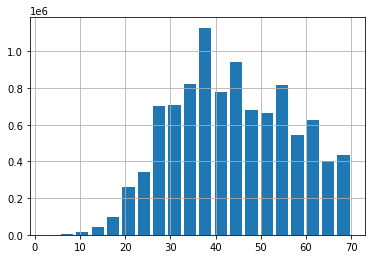

In [ ]:
train['SMILES'].str.len().hist(bins=20, rwidth=0.8)

In [ ]:
#train_1천만.csv라는 이름으로 저장
train.to_csv('./train_1천만.csv', index=False)

#### train_1천만.csv에 저장한 SMILES 분자식으로 이미지를 생성합니다

In [ ]:
#저장한 train.csv 불러오기
train = pd.read_csv('./train_1천만.csv')
train.shape

(10000000, 2)

중간에 선점형 인스턴스 종료나 에러로 인해 이미지 생성이 중단될 수 있으므로 prev_index를 지정해주어 다시 실행할때는 그 이후부터 생성하도록 하였습니다 

In [ ]:
# prev_index = 7642*256
# prev_index = 15000*256
prev_index = 0
train = train[prev_index:]

In [ ]:
train

,file_name,SMILES
0,train_0.png,C1=CC=C(C(=C1)/C=C/C(=CC(=O)/C=C/C2=CC=CC=C2F)O)F
1,train_1.png,CC1=CC(=C(C=C1C)S(=O)(=O)N(CCOC)C(C)C)N
2,train_2.png,CCC(C)C(=O)N1CCN(CC1)C(=O)C(C)O
3,train_3.png,C1[C@@H]([C@]1(CN2C=NC3=C2N=C(N=C3Cl)N)CO)CO
4,train_4.png,CCNC1=C2C(=NC=N1)N(C=N2)C3C(C4C(O3)COP(=O)(O4)O)O
...,...,...
9999995,train_9999995.png,CCOC(=O)C1=C(C=CC(=C1)NC(=O)C2=CC=C(C=C2)C(F)(...
9999996,train_9999996.png,CC1=C(C(=CC=C1)N2CCN(CC2)C(=NC)NCCCCN(C)C(C)C)C.I
9999997,train_9999997.png,CCCNC(=O)CN(C)CC(=O)C1=C(C=CC(=C1)F)OC
9999998,train_9999998.png,CC1=C(C=C(C=C1)NC(=O)C2=CC(=C(C(=C2)Cl)C)OC(C)C)C


In [ ]:
train.shape[0]

10000000

멀티 프로세싱을 위해 10000개씩 데이터를 나눕니다.

In [ ]:
train_list = []
for i in tqdm(range(train.shape[0]//10000+1)):
    train_list.append(np.array(train.loc[(10000*i)+prev_index : 10000*i+10000-1+prev_index, ['SMILES', 'file_name']]))

100%|██████████| 1001/1001 [00:01<00:00, 749.64it/s]


In [ ]:
#train 이미지를 생성한 후 저장할 폴더를 만듭니다(있다면 생략)
if not (os.path.isdir('train')):
    os.makedirs(os.path.join('train'))

In [ ]:
train_list[0].shape

(10000, 2)

간혹 rdkit으로 스마일즈 이미지가 생성이 되지 않는 경우가 있습니다.\
그래서 생성 코드에서 예외 처리를 하고 train.csv에도 이미지 생성에서 제외된 분자식을 지우고 다시 저장합니다.

In [3]:
#이미지 생성 코드
cpu_n = os.cpu_count()

error_smiles = []
def f(d):
    s, file = d

    #예외 처리
    try:
        m = Chem.MolFromSmiles(s)
        img = Draw.MolToImage(m, size=(300,300))
        img = np.array(img)
        cv2.imwrite('train/'+file, img)
    except:
        error_smiles.append(s)

for t in tqdm(train_list):
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes=cpu_n)
        pool.map(f,t)
        pool.close()
        pool.join()

In [ ]:
#train.csv에서 생성 안된 스마일즈 분자식 제거
for smiles in error_smiles:
    train = train[train['SMILES']!=smiles]

In [ ]:
error_smiles

[]

In [ ]:
#저장
train.to_csv('train_1천만_removed.csv', index=False)

## 2. tfrecord 포맷 파일 생성

In [ ]:
PATH = './train/'

In [ ]:
with open('./train_1천만_removed.csv', 'r') as csv_file:
# with open('/content/drive/My Drive/train_batch15000_30000_removed.csv', 'r') as csv_file:
    data = csv_file.read()
    
all_captions = []
all_img_name_vector = []

for line in data.split('\n')[1:-1]:
    image_id, smiles = line.split(',')
    caption = '<' + smiles + '>'
    full_image_path = PATH + image_id

    all_img_name_vector.append(full_image_path)
    all_captions.append(caption)
    
train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state=42)

num_examples = len(train_captions) # 학습에 사용할 데이터 수
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

### 텍스트 토큰화

smiles의 최대 길이를 확인합니다. 

꺽새(<,>)를 양쪽에 넣어주어 최대 길이가 72(70 + 2)로 나옵니다

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
max_length = calc_max_length(train_captions)
max_length

72

tf.keras.preprocessing.text.Tokenizer는 텍스트를 토큰화하기 위한 클래스 입니다. 

대소문자는 구분 할 것임으로 lower=False, 

smiles문자열을 글자수준으로 token화 할 것이기 때문에 char_level=True로 설정합니다.(1글자를 word단위로 보겠습니다)

train_captions에 있는 smiles데이터를 tokenizer에  fitting합니다. 

tokenizer.word_index는 글자,숫자 매핑 딕셔너리 입니다. 

In [ ]:
#토큰화 시작
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts(train_captions)
top_k = len(tokenizer.word_index)

#### tokenizer를 저장합니다.(모델 학습시에 다시 쓰입니다)

In [ ]:
import pickle
# saving
with open('./tokenizer_word36.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
top_k

36

smiles문자열을 정수 인덱스의 리스트로 변환합니다.

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

변환된 정수 인덱스의 리스트의 최대길이에 맞춰 padding을 추가합니다.

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector

array([[9, 1, 1, ..., 0, 0, 0],
       [9, 1, 1, ..., 0, 0, 0],
       [9, 1, 7, ..., 0, 0, 0],
       ...,
       [9, 1, 1, ..., 0, 0, 0],
       [9, 1, 7, ..., 0, 0, 0],
       [9, 1, 7, ..., 0, 0, 0]], dtype=int32)

#### TFRecord 데이터셋 구축
데이터 양이 많을 경우 이를 Binary로 Seralization한 뒤 파일 형태로 저장하고 있다가 이를 다시 읽어들이는 방식으로 처리하면 처리 속도가 향상됩니다. 특히 데이터를 네트워크로 주고받을 때에는 더욱 큰 이득을 볼 수 있습니다. 학습시 TPU를 사용할 계획이므로 GCS에 저장후 네트워크로 데이터를 TPU에 전송해야합니다. 텐서플로우의 TFrecords를 사용하면 Protocol Buffer형태로 Serialization을 수행하여 이미지와 레이블을 저장합니다

- Protocol Buffer는 구글에서 개발하고 오픈소스로 공개한, 직렬화 데이타 구조 (Serialized Data Structure)입니다

tf.train.Feature는 다음과 같은 메세지 타입을 지원합니다
    1. tf.train.BytesList – string, byte값으로부터 mapping
    2. tf.train.FloatList –  float (float32), double (float64) 값으로부터 mapping
    3. tf.train.Int64List – bool, enum, int32, uint32, int64, uint64 값으로부터 mapping

아래와 같이 함수를 만들어서 일반적인 Tensorflow Type을 tf.Example에 대응되는 tf.train.Feature 값으로 변환을 수행할 수 있습니다.

In [ ]:
# value를 tf.Example에 대응되는 형태로 변환하기 위한 함수들
def _bytes_feature(value):
    """string / byte 타입을 받아서 byte list를 리턴합니다."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """float / double 타입을 받아서 float list를 리턴합니다."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """bool / enum / int / uint 타입을 받아서 int64 list를 리턴합니다."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label':  _bytes_feature(label),
      'image_raw': _bytes_feature(image_string)
  }

    return tf.train.Example(features=tf.train.Features(feature=feature))

몇개씩 tfrecord에 저장할지 정해줍니다. 여기서는 256개씩 저장하였으나 
tfrecord파일 하나당 512*14개(90MB)의 이미지와 레이블을 저장하는 것이 좋습니다. 그렇게 하면 TPU가 GCS로부터 데이터를 읽어들일때 병목 현상이 최소화되어 처리량이 최대화됩니다.


In [ ]:
BATCH_SIZE = 256
target_size = 224

### tfrecord 형태로 저장

이미지와 라벨(smiles)을 위에서 정의한 image_example 함수에 입력으로 주면 

{“string” : “tf.train.Feature”} 형태로 데이터를 TFRecords 파일에 저장할 수 있는  tf.train.Example 객체를 리턴받습니다.

이를  .SerializeToString 함수를 이용해서 binary string으로 변환합니다.

tf.train.Example 객체에 담긴 proto messeage들이 .SerializeToString 함수를 이용해서 한번에 binary string으로 변환합니다. 

In [ ]:
#tfrecord 데이터셋 저장 함수
def tfrecord(lst_1, lst_2, record_file):
    with tf.io.TFRecordWriter(record_file) as writer:
        for j in range(len(lst_1)):
            image_string = open(lst_1[j], 'rb').read() #이미지 불러오기
            lst_2_string = lst_2[j].tostring() 
            tf_example = image_example(image_string, lst_2_string) #이미지 정보와 라벨
            writer.write(tf_example.SerializeToString())
            # os.remove(lst_1[j])
            

In [ ]:
#tfrecord 파일을 저장하고 싶은 폴더 경로를 적어줍니다.
perm_path = './tfrecord_3천만_300/'#실제론 1천만개만 이용하였습니다.
os.mkdir(perm_path)

In [ ]:
prev_index = 0 # 1천만개 이후 추가로 데이터셋을 만들때 이전 index를 설정해줍니다.

### tfrecord를 생성할때도 Multiprocessing을 이용하면 더욱 빠르게 생성할 수 있습니다.

tfrecord생성과정을 여러개의 process로 병렬 처리 하기 위해서

ilist에 i값을 bath_size단위로 샘플개수 범위만큼 저장합니다.

그후 ilist_list에 ilist값을 cpu코어 개수만큼 등분하여 나눠담습니다.

In [ ]:
ilist=[]
for i in tqdm(range(prev_index, prev_index + len(img_name_vector), BATCH_SIZE)):
    ilist.append(i)
    
# 한 리스트에 몇개씩 담을지 결정
n = len(ilist) // multiprocessing.cpu_count()
ilist_list = [ilist[i * n:(i + 1) * n] for i in range((len(ilist) + n - 1) // n )] 

100%|██████████| 39063/39063 [00:00<00:00, 1226812.96it/s]


pool의 map메소드를 활용해서 실행할 g_tf함수를 정의합니다.

In [ ]:
def g_tf(ilist) :
    for i in ilist:
        tfrecord_path = perm_path + 'batch_' + str(i + BATCH_SIZE) #저장할 디렉토리와 파일명 정의

        img_name_vector_new = img_name_vector[i:i + BATCH_SIZE] #배치 단위로 이미지 정보 저장하기 위해 이미지 이름 불러오기
        cap_vector_new = cap_vector[i:i + BATCH_SIZE] #배치 단위로 이미지 라벨 저장

        tfrecord(img_name_vector_new, cap_vector_new, tfrecord_path) #tfrecord_path에 저장
        print("pid : " + str(os.getpid()) + "에서  batch " + str(i+BATCH_SIZE)+ "완료")

In [ ]:
import multiprocessing
CPU_CORE = multiprocessing.cpu_count() # 멀티프로세싱 CPU 사용 수
if __name__=='__main__':
    pool = multiprocessing.Pool(processes=CPU_CORE)
    pool.map(g_tf, ilist_list)
    pool.close()
    pool.join()  

pid : 24650에서  batch 256완료
pid : 24660에서  batch 1253632완료
pid : 24662에서  batch 1880320완료
pid : 24659에서  batch 940288완료
pid : 24658에서  batch 626944완료
pid : 24669에서  batch 2193664완료
pid : 24657에서  batch 313600완료
pid : 24661에서  batch 1566976완료
pid : 24650에서  batch 512완료
pid : 24659에서  batch 940544완료
pid : 24669에서  batch 2193920완료
pid : 24662에서  batch 1880576완료
pid : 24657에서  batch 313856완료
pid : 24658에서  batch 627200완료
pid : 24660에서  batch 1253888완료
pid : 24661에서  batch 1567232완료
pid : 24650에서  batch 768완료
pid : 24659에서  batch 940800완료
pid : 24669에서  batch 2194176완료
pid : 24657에서  batch 314112완료
pid : 24658에서  batch 627456완료
pid : 24660에서  batch 1254144완료
pid : 24661에서  batch 1567488완료
pid : 24662에서  batch 1880832완료
pid : 24650에서  batch 1024완료
pid : 24659에서  batch 941056완료
pid : 24657에서  batch 314368완료
pid : 24658에서  batch 627712완료
pid : 24662에서  batch 1881088완료
pid : 24660에서  batch 1254400완료
pid : 24661에서  batch 1567744완료
pid : 24669에서  batch 2194432완료
pid : 24650에서  batch 1280완료
pid : 2

pid : 24669에서  batch 2210816완료
pid : 24657에서  batch 330752완료
pid : 24658에서  batch 644096완료
pid : 24650에서  batch 17664완료
pid : 24662에서  batch 1897472완료
pid : 24659에서  batch 957440완료
pid : 24661에서  batch 1584384완료
pid : 24660에서  batch 1271040완료
pid : 24669에서  batch 2211072완료
pid : 24657에서  batch 331008완료
pid : 24658에서  batch 644352완료
pid : 24650에서  batch 17920완료
pid : 24662에서  batch 1897728완료
pid : 24659에서  batch 957696완료
pid : 24660에서  batch 1271296완료
pid : 24661에서  batch 1584640완료
pid : 24669에서  batch 2211328완료
pid : 24658에서  batch 644608완료
pid : 24657에서  batch 331264완료
pid : 24662에서  batch 1897984완료
pid : 24650에서  batch 18176완료
pid : 24659에서  batch 957952완료
pid : 24660에서  batch 1271552완료
pid : 24658에서  batch 644864완료
pid : 24661에서  batch 1584896완료
pid : 24669에서  batch 2211584완료
pid : 24657에서  batch 331520완료
pid : 24650에서  batch 18432완료
pid : 24662에서  batch 1898240완료
pid : 24659에서  batch 958208완료
pid : 24660에서  batch 1271808완료
pid : 24658에서  batch 645120완료
pid : 24661에서  batch 1585152완

pid : 24658에서  batch 661248완료
pid : 24661에서  batch 1601280완료
pid : 24669에서  batch 2228224완료
pid : 24662에서  batch 1914624완료
pid : 24659에서  batch 974592완료
pid : 24657에서  batch 348160완료
pid : 24650에서  batch 35072완료
pid : 24660에서  batch 1288192완료
pid : 24658에서  batch 661504완료
pid : 24661에서  batch 1601536완료
pid : 24669에서  batch 2228480완료
pid : 24662에서  batch 1914880완료
pid : 24659에서  batch 974848완료
pid : 24650에서  batch 35328완료
pid : 24657에서  batch 348416완료
pid : 24660에서  batch 1288448완료
pid : 24658에서  batch 661760완료
pid : 24661에서  batch 1601792완료
pid : 24669에서  batch 2228736완료
pid : 24662에서  batch 1915136완료
pid : 24659에서  batch 975104완료
pid : 24650에서  batch 35584완료
pid : 24657에서  batch 348672완료
pid : 24660에서  batch 1288704완료
pid : 24658에서  batch 662016완료
pid : 24661에서  batch 1602048완료
pid : 24669에서  batch 2228992완료
pid : 24662에서  batch 1915392완료
pid : 24659에서  batch 975360완료
pid : 24650에서  batch 35840완료
pid : 24657에서  batch 348928완료
pid : 24660에서  batch 1288960완료
pid : 24658에서  batch 662272완

pid : 24669에서  batch 2245376완료
pid : 24657에서  batch 365312완료
pid : 24662에서  batch 1931776완료
pid : 24659에서  batch 991744완료
pid : 24660에서  batch 1305344완료
pid : 24661에서  batch 1618688완료
pid : 24658에서  batch 678656완료
pid : 24650에서  batch 52224완료
pid : 24669에서  batch 2245632완료
pid : 24657에서  batch 365568완료
pid : 24659에서  batch 992000완료
pid : 24662에서  batch 1932032완료
pid : 24660에서  batch 1305600완료
pid : 24661에서  batch 1618944완료
pid : 24658에서  batch 678912완료
pid : 24650에서  batch 52480완료
pid : 24657에서  batch 365824완료
pid : 24669에서  batch 2245888완료
pid : 24659에서  batch 992256완료
pid : 24662에서  batch 1932288완료
pid : 24660에서  batch 1305856완료
pid : 24661에서  batch 1619200완료
pid : 24658에서  batch 679168완료
pid : 24650에서  batch 52736완료
pid : 24669에서  batch 2246144완료
pid : 24657에서  batch 366080완료
pid : 24659에서  batch 992512완료
pid : 24660에서  batch 1306112완료
pid : 24662에서  batch 1932544완료
pid : 24661에서  batch 1619456완료
pid : 24658에서  batch 679424완료
pid : 24650에서  batch 52992완료
pid : 24669에서  batch 2246400

pid : 24650에서  batch 69120완료
pid : 24660에서  batch 1322496완료
pid : 24658에서  batch 695808완료
pid : 24659에서  batch 1008896완료
pid : 24669에서  batch 2262784완료
pid : 24661에서  batch 1635840완료
pid : 24662에서  batch 1948928완료
pid : 24657에서  batch 382720완료
pid : 24650에서  batch 69376완료
pid : 24660에서  batch 1322752완료
pid : 24658에서  batch 696064완료
pid : 24659에서  batch 1009152완료
pid : 24669에서  batch 2263040완료
pid : 24661에서  batch 1636096완료
pid : 24662에서  batch 1949184완료
pid : 24650에서  batch 69632완료
pid : 24657에서  batch 382976완료
pid : 24660에서  batch 1323008완료
pid : 24658에서  batch 696320완료
pid : 24659에서  batch 1009408완료
pid : 24669에서  batch 2263296완료
pid : 24661에서  batch 1636352완료
pid : 24662에서  batch 1949440완료
pid : 24650에서  batch 69888완료
pid : 24657에서  batch 383232완료
pid : 24660에서  batch 1323264완료
pid : 24658에서  batch 696576완료
pid : 24659에서  batch 1009664완료
pid : 24669에서  batch 2263552완료
pid : 24661에서  batch 1636608완료
pid : 24662에서  batch 1949696완료
pid : 24650에서  batch 70144완료
pid : 24657에서  batch 3834

pid : 24650에서  batch 86272완료
pid : 24660에서  batch 1339648완료
pid : 24659에서  batch 1026048완료
pid : 24658에서  batch 712960완료
pid : 24661에서  batch 1652992완료
pid : 24669에서  batch 2279936완료
pid : 24662에서  batch 1966080완료
pid : 24650에서  batch 86528완료
pid : 24657에서  batch 399872완료
pid : 24660에서  batch 1339904완료
pid : 24659에서  batch 1026304완료
pid : 24658에서  batch 713216완료
pid : 24661에서  batch 1653248완료
pid : 24669에서  batch 2280192완료
pid : 24662에서  batch 1966336완료
pid : 24657에서  batch 400128완료
pid : 24650에서  batch 86784완료
pid : 24660에서  batch 1340160완료
pid : 24659에서  batch 1026560완료
pid : 24658에서  batch 713472완료
pid : 24661에서  batch 1653504완료
pid : 24669에서  batch 2280448완료
pid : 24662에서  batch 1966592완료
pid : 24657에서  batch 400384완료
pid : 24650에서  batch 87040완료
pid : 24660에서  batch 1340416완료
pid : 24659에서  batch 1026816완료
pid : 24658에서  batch 713728완료
pid : 24661에서  batch 1653760완료
pid : 24669에서  batch 2280704완료
pid : 24657에서  batch 400640완료
pid : 24662에서  batch 1966848완료
pid : 24650에서  batch 872

pid : 24662에서  batch 1982976완료
pid : 24660에서  batch 1356800완료
pid : 24659에서  batch 1043200완료
pid : 24658에서  batch 730112완료
pid : 24669에서  batch 2297088완료
pid : 24657에서  batch 417024완료
pid : 24650에서  batch 103680완료
pid : 24661에서  batch 1670144완료
pid : 24662에서  batch 1983232완료
pid : 24659에서  batch 1043456완료
pid : 24660에서  batch 1357056완료
pid : 24658에서  batch 730368완료
pid : 24669에서  batch 2297344완료
pid : 24657에서  batch 417280완료
pid : 24650에서  batch 103936완료
pid : 24661에서  batch 1670400완료
pid : 24662에서  batch 1983488완료
pid : 24659에서  batch 1043712완료
pid : 24660에서  batch 1357312완료
pid : 24658에서  batch 730624완료
pid : 24669에서  batch 2297600완료
pid : 24657에서  batch 417536완료
pid : 24650에서  batch 104192완료
pid : 24661에서  batch 1670656완료
pid : 24662에서  batch 1983744완료
pid : 24659에서  batch 1043968완료
pid : 24660에서  batch 1357568완료
pid : 24658에서  batch 730880완료
pid : 24669에서  batch 2297856완료
pid : 24657에서  batch 417792완료
pid : 24650에서  batch 104448완료
pid : 24661에서  batch 1670912완료
pid : 24662에서  batch

pid : 24669에서  batch 2313984완료
pid : 24661에서  batch 1687040완료
pid : 24658에서  batch 747264완료
pid : 24662에서  batch 2000128완료
pid : 24657에서  batch 433920완료
pid : 24660에서  batch 1373952완료
pid : 24650에서  batch 120832완료
pid : 24659에서  batch 1060608완료
pid : 24658에서  batch 747520완료
pid : 24661에서  batch 1687296완료
pid : 24662에서  batch 2000384완료
pid : 24669에서  batch 2314240완료
pid : 24657에서  batch 434176완료
pid : 24660에서  batch 1374208완료
pid : 24650에서  batch 121088완료
pid : 24659에서  batch 1060864완료
pid : 24661에서  batch 1687552완료
pid : 24658에서  batch 747776완료
pid : 24669에서  batch 2314496완료
pid : 24662에서  batch 2000640완료
pid : 24657에서  batch 434432완료
pid : 24660에서  batch 1374464완료
pid : 24650에서  batch 121344완료
pid : 24659에서  batch 1061120완료
pid : 24661에서  batch 1687808완료
pid : 24669에서  batch 2314752완료
pid : 24658에서  batch 748032완료
pid : 24662에서  batch 2000896완료
pid : 24657에서  batch 434688완료
pid : 24660에서  batch 1374720완료
pid : 24650에서  batch 121600완료
pid : 24659에서  batch 1061376완료
pid : 24661에서  batch

pid : 24650에서  batch 137728완료
pid : 24659에서  batch 1077504완료
pid : 24669에서  batch 2331136완료
pid : 24658에서  batch 764416완료
pid : 24662에서  batch 2017280완료
pid : 24657에서  batch 451072완료
pid : 24661에서  batch 1704192완료
pid : 24660에서  batch 1391104완료
pid : 24650에서  batch 137984완료
pid : 24659에서  batch 1077760완료
pid : 24658에서  batch 764672완료
pid : 24669에서  batch 2331392완료
pid : 24662에서  batch 2017536완료
pid : 24657에서  batch 451328완료
pid : 24661에서  batch 1704448완료
pid : 24660에서  batch 1391360완료
pid : 24650에서  batch 138240완료
pid : 24659에서  batch 1078016완료
pid : 24669에서  batch 2331648완료
pid : 24658에서  batch 764928완료
pid : 24662에서  batch 2017792완료
pid : 24657에서  batch 451584완료
pid : 24661에서  batch 1704704완료
pid : 24660에서  batch 1391616완료
pid : 24650에서  batch 138496완료
pid : 24659에서  batch 1078272완료
pid : 24669에서  batch 2331904완료
pid : 24658에서  batch 765184완료
pid : 24662에서  batch 2018048완료
pid : 24657에서  batch 451840완료
pid : 24661에서  batch 1704960완료
pid : 24660에서  batch 1391872완료
pid : 24650에서  batch

pid : 24660에서  batch 1408000완료
pid : 24661에서  batch 1721088완료
pid : 24659에서  batch 1094656완료
pid : 24650에서  batch 154880완료
pid : 24658에서  batch 781568완료
pid : 24657에서  batch 468224완료
pid : 24669에서  batch 2348288완료
pid : 24662에서  batch 2034432완료
pid : 24660에서  batch 1408256완료
pid : 24661에서  batch 1721344완료
pid : 24659에서  batch 1094912완료
pid : 24650에서  batch 155136완료
pid : 24658에서  batch 781824완료
pid : 24657에서  batch 468480완료
pid : 24669에서  batch 2348544완료
pid : 24662에서  batch 2034688완료
pid : 24660에서  batch 1408512완료
pid : 24661에서  batch 1721600완료
pid : 24659에서  batch 1095168완료
pid : 24650에서  batch 155392완료
pid : 24658에서  batch 782080완료
pid : 24657에서  batch 468736완료
pid : 24669에서  batch 2348800완료
pid : 24662에서  batch 2034944완료
pid : 24660에서  batch 1408768완료
pid : 24661에서  batch 1721856완료
pid : 24659에서  batch 1095424완료
pid : 24650에서  batch 155648완료
pid : 24658에서  batch 782336완료
pid : 24657에서  batch 468992완료
pid : 24669에서  batch 2349056완료
pid : 24662에서  batch 2035200완료
pid : 24660에서  batch

pid : 24669에서  batch 2365184완료
pid : 24662에서  batch 2051328완료
pid : 24660에서  batch 1425152완료
pid : 24661에서  batch 1738240완료
pid : 24659에서  batch 1111808완료
pid : 24650에서  batch 172032완료
pid : 24658에서  batch 798720완료
pid : 24657에서  batch 485376완료
pid : 24669에서  batch 2365440완료
pid : 24662에서  batch 2051584완료
pid : 24660에서  batch 1425408완료
pid : 24661에서  batch 1738496완료
pid : 24659에서  batch 1112064완료
pid : 24650에서  batch 172288완료
pid : 24658에서  batch 798976완료
pid : 24657에서  batch 485632완료
pid : 24669에서  batch 2365696완료
pid : 24662에서  batch 2051840완료
pid : 24660에서  batch 1425664완료
pid : 24661에서  batch 1738752완료
pid : 24659에서  batch 1112320완료
pid : 24650에서  batch 172544완료
pid : 24658에서  batch 799232완료
pid : 24657에서  batch 485888완료
pid : 24669에서  batch 2365952완료
pid : 24662에서  batch 2052096완료
pid : 24660에서  batch 1425920완료
pid : 24661에서  batch 1739008완료
pid : 24659에서  batch 1112576완료
pid : 24650에서  batch 172800완료
pid : 24658에서  batch 799488완료
pid : 24657에서  batch 486144완료
pid : 24669에서  batch

pid : 24669에서  batch 2382336완료
pid : 24657에서  batch 502272완료
pid : 24658에서  batch 815616완료
pid : 24660에서  batch 1442304완료
pid : 24662에서  batch 2068480완료
pid : 24650에서  batch 189184완료
pid : 24661에서  batch 1755392완료
pid : 24659에서  batch 1128960완료
pid : 24669에서  batch 2382592완료
pid : 24657에서  batch 502528완료
pid : 24658에서  batch 815872완료
pid : 24660에서  batch 1442560완료
pid : 24662에서  batch 2068736완료
pid : 24661에서  batch 1755648완료pid : 24650에서  batch 189440완료

pid : 24659에서  batch 1129216완료
pid : 24669에서  batch 2382848완료
pid : 24657에서  batch 502784완료
pid : 24658에서  batch 816128완료
pid : 24660에서  batch 1442816완료
pid : 24662에서  batch 2068992완료
pid : 24661에서  batch 1755904완료
pid : 24650에서  batch 189696완료
pid : 24659에서  batch 1129472완료
pid : 24669에서  batch 2383104완료
pid : 24657에서  batch 503040완료
pid : 24658에서  batch 816384완료
pid : 24660에서  batch 1443072완료
pid : 24662에서  batch 2069248완료
pid : 24661에서  batch 1756160완료
pid : 24650에서  batch 189952완료
pid : 24659에서  batch 1129728완료
pid : 24669에서  batch

pid : 24669에서  batch 2399488완료
pid : 24659에서  batch 1145856완료
pid : 24661에서  batch 1772288완료
pid : 24662에서  batch 2085632완료
pid : 24658에서  batch 832768완료
pid : 24657에서  batch 519424완료
pid : 24660에서  batch 1459456완료
pid : 24650에서  batch 206336완료
pid : 24669에서  batch 2399744완료
pid : 24659에서  batch 1146112완료
pid : 24661에서  batch 1772544완료
pid : 24662에서  batch 2085888완료
pid : 24658에서  batch 833024완료
pid : 24660에서  batch 1459712완료
pid : 24657에서  batch 519680완료
pid : 24650에서  batch 206592완료
pid : 24669에서  batch 2400000완료
pid : 24659에서  batch 1146368완료
pid : 24661에서  batch 1772800완료
pid : 24662에서  batch 2086144완료
pid : 24658에서  batch 833280완료
pid : 24660에서  batch 1459968완료
pid : 24657에서  batch 519936완료
pid : 24669에서  batch 2400256완료
pid : 24650에서  batch 206848완료
pid : 24659에서  batch 1146624완료
pid : 24661에서  batch 1773056완료
pid : 24662에서  batch 2086400완료
pid : 24658에서  batch 833536완료
pid : 24660에서  batch 1460224완료
pid : 24657에서  batch 520192완료
pid : 24669에서  batch 2400512완료
pid : 24650에서  batc

pid : 24658에서  batch 849664완료
pid : 24650에서  batch 223232완료
pid : 24669에서  batch 2416640완료
pid : 24660에서  batch 1476352완료
pid : 24661에서  batch 1789440완료
pid : 24662에서  batch 2102784완료
pid : 24659에서  batch 1163264완료
pid : 24658에서  batch 849920완료
pid : 24657에서  batch 536576완료
pid : 24650에서  batch 223488완료
pid : 24660에서  batch 1476608완료
pid : 24669에서  batch 2416896완료
pid : 24661에서  batch 1789696완료
pid : 24662에서  batch 2103040완료
pid : 24659에서  batch 1163520완료
pid : 24658에서  batch 850176완료
pid : 24657에서  batch 536832완료
pid : 24650에서  batch 223744완료
pid : 24660에서  batch 1476864완료
pid : 24669에서  batch 2417152완료
pid : 24661에서  batch 1789952완료
pid : 24662에서  batch 2103296완료
pid : 24659에서  batch 1163776완료
pid : 24657에서  batch 537088완료
pid : 24658에서  batch 850432완료
pid : 24650에서  batch 224000완료
pid : 24660에서  batch 1477120완료
pid : 24669에서  batch 2417408완료
pid : 24661에서  batch 1790208완료
pid : 24662에서  batch 2103552완료
pid : 24659에서  batch 1164032완료
pid : 24657에서  batch 537344완료
pid : 24658에서  batch

pid : 24659에서  batch 1180160완료
pid : 24657에서  batch 553472완료
pid : 24658에서  batch 866816완료
pid : 24650에서  batch 240384완료
pid : 24660에서  batch 1493504완료
pid : 24669에서  batch 2433792완료
pid : 24662에서  batch 2119936완료
pid : 24661에서  batch 1806592완료
pid : 24659에서  batch 1180416완료
pid : 24657에서  batch 553728완료
pid : 24658에서  batch 867072완료
pid : 24650에서  batch 240640완료
pid : 24660에서  batch 1493760완료
pid : 24669에서  batch 2434048완료
pid : 24659에서  batch 1180672완료
pid : 24662에서  batch 2120192완료
pid : 24661에서  batch 1806848완료
pid : 24657에서  batch 553984완료
pid : 24658에서  batch 867328완료
pid : 24650에서  batch 240896완료
pid : 24660에서  batch 1494016완료
pid : 24669에서  batch 2434304완료
pid : 24661에서  batch 1807104완료
pid : 24659에서  batch 1180928완료
pid : 24662에서  batch 2120448완료
pid : 24657에서  batch 554240완료
pid : 24658에서  batch 867584완료
pid : 24650에서  batch 241152완료
pid : 24660에서  batch 1494272완료
pid : 24669에서  batch 2434560완료
pid : 24661에서  batch 1807360완료
pid : 24662에서  batch 2120704완료
pid : 24659에서  batch

pid : 24659에서  batch 1197312완료
pid : 24657에서  batch 570624완료
pid : 24661에서  batch 1823488완료
pid : 24662에서  batch 2136832완료
pid : 24650에서  batch 257536완료
pid : 24658에서  batch 883968완료
pid : 24660에서  batch 1510656완료
pid : 24659에서  batch 1197568완료
pid : 24669에서  batch 2450944완료
pid : 24661에서  batch 1823744완료
pid : 24657에서  batch 570880완료
pid : 24662에서  batch 2137088완료
pid : 24650에서  batch 257792완료
pid : 24658에서  batch 884224완료
pid : 24660에서  batch 1510912완료
pid : 24659에서  batch 1197824완료
pid : 24669에서  batch 2451200완료
pid : 24657에서  batch 571136완료
pid : 24661에서  batch 1824000완료
pid : 24662에서  batch 2137344완료
pid : 24658에서  batch 884480완료
pid : 24650에서  batch 258048완료
pid : 24660에서  batch 1511168완료
pid : 24659에서  batch 1198080완료
pid : 24669에서  batch 2451456완료
pid : 24657에서  batch 571392완료
pid : 24661에서  batch 1824256완료
pid : 24662에서  batch 2137600완료
pid : 24658에서  batch 884736완료
pid : 24650에서  batch 258304완료
pid : 24660에서  batch 1511424완료
pid : 24659에서  batch 1198336완료
pid : 24669에서  batch

pid : 24659에서  batch 1214464완료
pid : 24669에서  batch 2467840완료
pid : 24660에서  batch 1527552완료
pid : 24650에서  batch 274688완료
pid : 24661에서  batch 1840640완료
pid : 24662에서  batch 2153984완료
pid : 24657에서  batch 587776완료
pid : 24658에서  batch 901120완료
pid : 24659에서  batch 1214720완료
pid : 24669에서  batch 2468096완료
pid : 24650에서  batch 274944완료
pid : 24660에서  batch 1527808완료
pid : 24661에서  batch 1840896완료
pid : 24662에서  batch 2154240완료
pid : 24657에서  batch 588032완료
pid : 24658에서  batch 901376완료
pid : 24659에서  batch 1214976완료
pid : 24669에서  batch 2468352완료
pid : 24661에서  batch 1841152완료
pid : 24660에서  batch 1528064완료
pid : 24650에서  batch 275200완료
pid : 24662에서  batch 2154496완료
pid : 24657에서  batch 588288완료
pid : 24658에서  batch 901632완료
pid : 24659에서  batch 1215232완료
pid : 24669에서  batch 2468608완료
pid : 24660에서  batch 1528320완료
pid : 24661에서  batch 1841408완료
pid : 24650에서  batch 275456완료
pid : 24662에서  batch 2154752완료
pid : 24657에서  batch 588544완료
pid : 24658에서  batch 901888완료
pid : 24659에서  batch

pid : 24657에서  batch 604672완료
pid : 24659에서  batch 1231616완료
pid : 24658에서  batch 918016완료
pid : 24669에서  batch 2484992완료
pid : 24660에서  batch 1544704완료
pid : 24650에서  batch 291840완료
pid : 24662에서  batch 2171136완료
pid : 24661에서  batch 1857792완료
pid : 24657에서  batch 604928완료
pid : 24659에서  batch 1231872완료
pid : 24658에서  batch 918272완료
pid : 24669에서  batch 2485248완료
pid : 24660에서  batch 1544960완료
pid : 24650에서  batch 292096완료
pid : 24662에서  batch 2171392완료
pid : 24661에서  batch 1858048완료
pid : 24657에서  batch 605184완료
pid : 24659에서  batch 1232128완료
pid : 24658에서  batch 918528완료
pid : 24669에서  batch 2485504완료
pid : 24660에서  batch 1545216완료
pid : 24650에서  batch 292352완료
pid : 24662에서  batch 2171648완료
pid : 24661에서  batch 1858304완료
pid : 24657에서  batch 605440완료
pid : 24659에서  batch 1232384완료
pid : 24658에서  batch 918784완료
pid : 24669에서  batch 2485760완료
pid : 24660에서  batch 1545472완료
pid : 24650에서  batch 292608완료
pid : 24662에서  batch 2171904완료
pid : 24661에서  batch 1858560완료
pid : 24657에서  batch

pid : 24657에서  batch 621824완료
pid : 24662에서  batch 2188032완료
pid : 24650에서  batch 308736완료
pid : 24659에서  batch 1248768완료
pid : 24669에서  batch 2502144완료
pid : 24658에서  batch 935168완료
pid : 24660에서  batch 1561856완료
pid : 24661에서  batch 1874944완료
pid : 24657에서  batch 622080완료
pid : 24662에서  batch 2188288완료
pid : 24650에서  batch 308992완료
pid : 24659에서  batch 1249024완료
pid : 24669에서  batch 2502400완료
pid : 24658에서  batch 935424완료
pid : 24660에서  batch 1562112완료
pid : 24661에서  batch 1875200완료
pid : 24657에서  batch 622336완료
pid : 24662에서  batch 2188544완료
pid : 24650에서  batch 309248완료
pid : 24659에서  batch 1249280완료
pid : 24658에서  batch 935680완료
pid : 24669에서  batch 2502656완료
pid : 24660에서  batch 1562368완료
pid : 24661에서  batch 1875456완료
pid : 24657에서  batch 622592완료
pid : 24662에서  batch 2188800완료
pid : 24650에서  batch 309504완료
pid : 24659에서  batch 1249536완료
pid : 24658에서  batch 935936완료
pid : 24669에서  batch 2502912완료
pid : 24660에서  batch 1562624완료
pid : 24661에서  batch 1875712완료
pid : 24657에서  batch

pid : 24660에서  batch 4085504완료
pid : 24650에서  batch 2519040완료
pid : 24659에서  batch 2832384완료
pid : 24669에서  batch 3145728완료
pid : 24662에서  batch 4711936완료
pid : 24661에서  batch 4398592완료
pid : 24658에서  batch 3772160완료
pid : 24657에서  batch 3459072완료
pid : 24660에서  batch 4085760완료
pid : 24650에서  batch 2519296완료
pid : 24659에서  batch 2832640완료
pid : 24669에서  batch 3145984완료
pid : 24662에서  batch 4712192완료
pid : 24661에서  batch 4398848완료
pid : 24657에서  batch 3459328완료
pid : 24658에서  batch 3772416완료
pid : 24660에서  batch 4086016완료
pid : 24650에서  batch 2519552완료
pid : 24659에서  batch 2832896완료
pid : 24669에서  batch 3146240완료
pid : 24662에서  batch 4712448완료
pid : 24661에서  batch 4399104완료
pid : 24657에서  batch 3459584완료pid : 24658에서  batch 3772672완료

pid : 24660에서  batch 4086272완료
pid : 24650에서  batch 2519808완료
pid : 24659에서  batch 2833152완료
pid : 24669에서  batch 3146496완료
pid : 24662에서  batch 4712704완료
pid : 24661에서  batch 4399360완료
pid : 24657에서  batch 3459840완료
pid : 24658에서  batch 3772928완료
pid : 24

pid : 24650에서  batch 2535936완료
pid : 24660에서  batch 4102400완료
pid : 24659에서  batch 2849280완료
pid : 24669에서  batch 3162624완료
pid : 24662에서  batch 4728832완료
pid : 24657에서  batch 3475968완료
pid : 24661에서  batch 4415488완료
pid : 24658에서  batch 3789056완료
pid : 24650에서  batch 2536192완료
pid : 24660에서  batch 4102656완료
pid : 24659에서  batch 2849536완료
pid : 24669에서  batch 3162880완료
pid : 24657에서  batch 3476224완료
pid : 24662에서  batch 4729088완료
pid : 24661에서  batch 4415744완료
pid : 24658에서  batch 3789312완료
pid : 24650에서  batch 2536448완료
pid : 24659에서  batch 2849792완료
pid : 24660에서  batch 4102912완료
pid : 24669에서  batch 3163136완료
pid : 24657에서  batch 3476480완료
pid : 24662에서  batch 4729344완료
pid : 24661에서  batch 4416000완료
pid : 24658에서  batch 3789568완료
pid : 24650에서  batch 2536704완료
pid : 24659에서  batch 2850048완료
pid : 24660에서  batch 4103168완료
pid : 24669에서  batch 3163392완료
pid : 24657에서  batch 3476736완료
pid : 24661에서  batch 4416256완료
pid : 24662에서  batch 4729600완료
pid : 24658에서  batch 3789824완료
pid : 24

pid : 24669에서  batch 3179520완료
pid : 24662에서  batch 4745472완료
pid : 24660에서  batch 4119296완료
pid : 24661에서  batch 4432384완료
pid : 24659에서  batch 2866176완료
pid : 24657에서  batch 3492864완료
pid : 24650에서  batch 2553088완료
pid : 24658에서  batch 3805952완료
pid : 24669에서  batch 3179776완료
pid : 24662에서  batch 4745728완료
pid : 24660에서  batch 4119552완료
pid : 24661에서  batch 4432640완료
pid : 24659에서  batch 2866432완료
pid : 24657에서  batch 3493120완료
pid : 24650에서  batch 2553344완료
pid : 24658에서  batch 3806208완료
pid : 24669에서  batch 3180032완료
pid : 24660에서  batch 4119808완료
pid : 24662에서  batch 4745984완료
pid : 24659에서  batch 2866688완료
pid : 24661에서  batch 4432896완료
pid : 24657에서  batch 3493376완료
pid : 24650에서  batch 2553600완료
pid : 24658에서  batch 3806464완료
pid : 24669에서  batch 3180288완료
pid : 24660에서  batch 4120064완료
pid : 24662에서  batch 4746240완료
pid : 24661에서  batch 4433152완료
pid : 24659에서  batch 2866944완료
pid : 24657에서  batch 3493632완료
pid : 24650에서  batch 2553856완료
pid : 24658에서  batch 3806720완료
pid : 24

pid : 24662에서  batch 4762368완료
pid : 24669에서  batch 3196416완료
pid : 24650에서  batch 2569984완료
pid : 24660에서  batch 4136192완료
pid : 24659에서  batch 2883072완료
pid : 24657에서  batch 3509760완료
pid : 24661에서  batch 4449280완료
pid : 24658에서  batch 3822848완료
pid : 24662에서  batch 4762624완료
pid : 24669에서  batch 3196672완료
pid : 24650에서  batch 2570240완료
pid : 24660에서  batch 4136448완료
pid : 24659에서  batch 2883328완료
pid : 24657에서  batch 3510016완료
pid : 24661에서  batch 4449536완료
pid : 24658에서  batch 3823104완료
pid : 24662에서  batch 4762880완료
pid : 24669에서  batch 3196928완료
pid : 24650에서  batch 2570496완료
pid : 24660에서  batch 4136704완료
pid : 24659에서  batch 2883584완료
pid : 24657에서  batch 3510272완료
pid : 24661에서  batch 4449792완료
pid : 24658에서  batch 3823360완료
pid : 24662에서  batch 4763136완료
pid : 24669에서  batch 3197184완료
pid : 24650에서  batch 2570752완료
pid : 24659에서  batch 2883840완료
pid : 24660에서  batch 4136960완료
pid : 24657에서  batch 3510528완료
pid : 24661에서  batch 4450048완료
pid : 24658에서  batch 3823616완료
pid : 24

pid : 24662에서  batch 4779264완료
pid : 24669에서  batch 3213312완료
pid : 24650에서  batch 2586880완료
pid : 24660에서  batch 4153088완료
pid : 24657에서  batch 3526656완료
pid : 24661에서  batch 4466176완료
pid : 24659에서  batch 2899968완료
pid : 24658에서  batch 3839744완료
pid : 24669에서  batch 3213568완료
pid : 24662에서  batch 4779520완료
pid : 24650에서  batch 2587136완료
pid : 24660에서  batch 4153344완료
pid : 24657에서  batch 3526912완료
pid : 24661에서  batch 4466432완료
pid : 24658에서  batch 3840000완료
pid : 24659에서  batch 2900224완료
pid : 24662에서  batch 4779776완료
pid : 24669에서  batch 3213824완료
pid : 24650에서  batch 2587392완료
pid : 24660에서  batch 4153600완료
pid : 24657에서  batch 3527168완료
pid : 24661에서  batch 4466688완료
pid : 24658에서  batch 3840256완료
pid : 24659에서  batch 2900480완료
pid : 24662에서  batch 4780032완료
pid : 24669에서  batch 3214080완료
pid : 24650에서  batch 2587648완료
pid : 24660에서  batch 4153856완료
pid : 24657에서  batch 3527424완료
pid : 24661에서  batch 4466944완료
pid : 24658에서  batch 3840512완료
pid : 24659에서  batch 2900736완료
pid : 24

pid : 24669에서  batch 3230208완료
pid : 24662에서  batch 4796160완료
pid : 24660에서  batch 4169984완료
pid : 24650에서  batch 2603776완료
pid : 24659에서  batch 2916864완료
pid : 24661에서  batch 4483072완료
pid : 24658에서  batch 3856640완료
pid : 24657에서  batch 3543552완료
pid : 24662에서  batch 4796416완료
pid : 24669에서  batch 3230464완료
pid : 24660에서  batch 4170240완료
pid : 24650에서  batch 2604032완료
pid : 24659에서  batch 2917120완료
pid : 24661에서  batch 4483328완료
pid : 24657에서  batch 3543808완료
pid : 24658에서  batch 3856896완료
pid : 24669에서  batch 3230720완료
pid : 24662에서  batch 4796672완료
pid : 24660에서  batch 4170496완료
pid : 24650에서  batch 2604288완료
pid : 24659에서  batch 2917376완료
pid : 24661에서  batch 4483584완료
pid : 24658에서  batch 3857152완료
pid : 24657에서  batch 3544064완료
pid : 24669에서  batch 3230976완료
pid : 24662에서  batch 4796928완료
pid : 24660에서  batch 4170752완료
pid : 24650에서  batch 2604544완료
pid : 24659에서  batch 2917632완료
pid : 24661에서  batch 4483840완료
pid : 24657에서  batch 3544320완료
pid : 24658에서  batch 3857408완료
pid : 24

pid : 24669에서  batch 3247104완료
pid : 24658에서  batch 3873280완료
pid : 24660에서  batch 4186880완료
pid : 24661에서  batch 4499968완료
pid : 24662에서  batch 4813056완료
pid : 24659에서  batch 2933760완료
pid : 24657에서  batch 3560448완료
pid : 24650에서  batch 2620928완료
pid : 24669에서  batch 3247360완료
pid : 24658에서  batch 3873536완료
pid : 24660에서  batch 4187136완료
pid : 24661에서  batch 4500224완료
pid : 24659에서  batch 2934016완료
pid : 24662에서  batch 4813312완료
pid : 24657에서  batch 3560704완료
pid : 24650에서  batch 2621184완료
pid : 24669에서  batch 3247616완료
pid : 24658에서  batch 3873792완료
pid : 24660에서  batch 4187392완료
pid : 24661에서  batch 4500480완료
pid : 24659에서  batch 2934272완료
pid : 24662에서  batch 4813568완료
pid : 24657에서  batch 3560960완료
pid : 24650에서  batch 2621440완료
pid : 24669에서  batch 3247872완료
pid : 24658에서  batch 3874048완료
pid : 24661에서  batch 4500736완료
pid : 24660에서  batch 4187648완료
pid : 24659에서  batch 2934528완료
pid : 24662에서  batch 4813824완료
pid : 24657에서  batch 3561216완료
pid : 24650에서  batch 2621696완료
pid : 24

pid : 24661에서  batch 4516864완료
pid : 24650에서  batch 2637568완료
pid : 24669에서  batch 3264000완료
pid : 24662에서  batch 4829952완료
pid : 24659에서  batch 2950656완료
pid : 24660에서  batch 4203776완료
pid : 24657에서  batch 3577344완료
pid : 24658에서  batch 3890432완료
pid : 24661에서  batch 4517120완료
pid : 24669에서  batch 3264256완료
pid : 24650에서  batch 2637824완료
pid : 24662에서  batch 4830208완료
pid : 24659에서  batch 2950912완료
pid : 24660에서  batch 4204032완료
pid : 24657에서  batch 3577600완료
pid : 24658에서  batch 3890688완료
pid : 24661에서  batch 4517376완료
pid : 24669에서  batch 3264512완료
pid : 24650에서  batch 2638080완료
pid : 24662에서  batch 4830464완료
pid : 24659에서  batch 2951168완료
pid : 24660에서  batch 4204288완료
pid : 24657에서  batch 3577856완료
pid : 24658에서  batch 3890944완료
pid : 24661에서  batch 4517632완료
pid : 24669에서  batch 3264768완료
pid : 24650에서  batch 2638336완료
pid : 24662에서  batch 4830720완료
pid : 24660에서  batch 4204544완료
pid : 24659에서  batch 2951424완료
pid : 24657에서  batch 3578112완료
pid : 24658에서  batch 3891200완료
pid : 24

pid : 24661에서  batch 4533760완료
pid : 24658에서  batch 3907072완료
pid : 24650에서  batch 2654464완료
pid : 24659에서  batch 2967552완료
pid : 24662에서  batch 4846848완료
pid : 24660에서  batch 4220672완료
pid : 24669에서  batch 3281152완료
pid : 24657에서  batch 3594240완료
pid : 24661에서  batch 4534016완료
pid : 24658에서  batch 3907328완료
pid : 24650에서  batch 2654720완료
pid : 24659에서  batch 2967808완료
pid : 24662에서  batch 4847104완료
pid : 24660에서  batch 4220928완료
pid : 24669에서  batch 3281408완료
pid : 24657에서  batch 3594496완료
pid : 24661에서  batch 4534272완료
pid : 24658에서  batch 3907584완료
pid : 24659에서  batch 2968064완료
pid : 24650에서  batch 2654976완료
pid : 24662에서  batch 4847360완료
pid : 24669에서  batch 3281664완료pid : 24660에서  batch 4221184완료

pid : 24657에서  batch 3594752완료
pid : 24661에서  batch 4534528완료
pid : 24658에서  batch 3907840완료
pid : 24659에서  batch 2968320완료
pid : 24650에서  batch 2655232완료
pid : 24662에서  batch 4847616완료
pid : 24660에서  batch 4221440완료
pid : 24669에서  batch 3281920완료
pid : 24657에서  batch 3595008완료
pid : 24

pid : 24650에서  batch 2671360완료
pid : 24658에서  batch 3923968완료
pid : 24661에서  batch 4550656완료
pid : 24659에서  batch 2984448완료
pid : 24662에서  batch 4863744완료
pid : 24660에서  batch 4237568완료
pid : 24669에서  batch 3298048완료
pid : 24657에서  batch 3611136완료
pid : 24650에서  batch 2671616완료
pid : 24658에서  batch 3924224완료pid : 24661에서  batch 4550912완료

pid : 24659에서  batch 2984704완료
pid : 24662에서  batch 4864000완료
pid : 24660에서  batch 4237824완료
pid : 24669에서  batch 3298304완료
pid : 24657에서  batch 3611392완료
pid : 24650에서  batch 2671872완료
pid : 24661에서  batch 4551168완료
pid : 24658에서  batch 3924480완료
pid : 24659에서  batch 2984960완료
pid : 24662에서  batch 4864256완료
pid : 24660에서  batch 4238080완료
pid : 24669에서  batch 3298560완료
pid : 24657에서  batch 3611648완료
pid : 24661에서  batch 4551424완료
pid : 24650에서  batch 2672128완료
pid : 24658에서  batch 3924736완료
pid : 24659에서  batch 2985216완료
pid : 24662에서  batch 4864512완료
pid : 24660에서  batch 4238336완료
pid : 24669에서  batch 3298816완료
pid : 24657에서  batch 3611904완료
pid : 24

pid : 24657에서  batch 3627776완료
pid : 24658에서  batch 3940864완료
pid : 24659에서  batch 3001344완료
pid : 24650에서  batch 2688256완료
pid : 24660에서  batch 4254464완료
pid : 24669에서  batch 3314944완료
pid : 24662에서  batch 4880640완료
pid : 24661에서  batch 4567808완료
pid : 24657에서  batch 3628032완료
pid : 24658에서  batch 3941120완료
pid : 24659에서  batch 3001600완료
pid : 24650에서  batch 2688512완료
pid : 24660에서  batch 4254720완료
pid : 24669에서  batch 3315200완료
pid : 24662에서  batch 4880896완료
pid : 24661에서  batch 4568064완료
pid : 24657에서  batch 3628288완료
pid : 24658에서  batch 3941376완료
pid : 24659에서  batch 3001856완료
pid : 24650에서  batch 2688768완료
pid : 24660에서  batch 4254976완료
pid : 24669에서  batch 3315456완료
pid : 24662에서  batch 4881152완료
pid : 24661에서  batch 4568320완료
pid : 24657에서  batch 3628544완료
pid : 24658에서  batch 3941632완료
pid : 24659에서  batch 3002112완료
pid : 24650에서  batch 2689024완료
pid : 24660에서  batch 4255232완료
pid : 24669에서  batch 3315712완료
pid : 24662에서  batch 4881408완료
pid : 24661에서  batch 4568576완료
pid : 24

pid : 24659에서  batch 3018240완료
pid : 24650에서  batch 2705152완료
pid : 24660에서  batch 4271360완료
pid : 24661에서  batch 4584448완료
pid : 24657에서  batch 3644672완료
pid : 24658에서  batch 3958016완료
pid : 24669에서  batch 3331840완료
pid : 24662에서  batch 4897536완료
pid : 24659에서  batch 3018496완료
pid : 24650에서  batch 2705408완료
pid : 24661에서  batch 4584704완료
pid : 24660에서  batch 4271616완료
pid : 24657에서  batch 3644928완료
pid : 24658에서  batch 3958272완료
pid : 24669에서  batch 3332096완료
pid : 24662에서  batch 4897792완료
pid : 24659에서  batch 3018752완료
pid : 24661에서  batch 4584960완료
pid : 24650에서  batch 2705664완료
pid : 24660에서  batch 4271872완료
pid : 24657에서  batch 3645184완료
pid : 24658에서  batch 3958528완료
pid : 24669에서  batch 3332352완료
pid : 24662에서  batch 4898048완료
pid : 24659에서  batch 3019008완료
pid : 24661에서  batch 4585216완료
pid : 24650에서  batch 2705920완료
pid : 24660에서  batch 4272128완료
pid : 24657에서  batch 3645440완료
pid : 24658에서  batch 3958784완료
pid : 24669에서  batch 3332608완료
pid : 24662에서  batch 4898304완료
pid : 24

pid : 24659에서  batch 3035136완료
pid : 24661에서  batch 4601344완료
pid : 24657에서  batch 3661568완료
pid : 24658에서  batch 3974912완료
pid : 24662에서  batch 4914176완료
pid : 24660에서  batch 4288256완료
pid : 24669에서  batch 3348736완료
pid : 24659에서  batch 3035392완료
pid : 24650에서  batch 2722304완료
pid : 24661에서  batch 4601600완료
pid : 24658에서  batch 3975168완료
pid : 24657에서  batch 3661824완료
pid : 24662에서  batch 4914432완료
pid : 24660에서  batch 4288512완료
pid : 24669에서  batch 3348992완료
pid : 24650에서  batch 2722560완료
pid : 24659에서  batch 3035648완료
pid : 24661에서  batch 4601856완료
pid : 24658에서  batch 3975424완료
pid : 24657에서  batch 3662080완료
pid : 24662에서  batch 4914688완료
pid : 24660에서  batch 4288768완료
pid : 24669에서  batch 3349248완료
pid : 24659에서  batch 3035904완료
pid : 24650에서  batch 2722816완료
pid : 24661에서  batch 4602112완료
pid : 24658에서  batch 3975680완료
pid : 24657에서  batch 3662336완료
pid : 24662에서  batch 4914944완료
pid : 24660에서  batch 4289024완료
pid : 24669에서  batch 3349504완료
pid : 24659에서  batch 3036160완료
pid : 24

pid : 24657에서  batch 3678464완료
pid : 24661에서  batch 4618240완료
pid : 24659에서  batch 3052032완료
pid : 24660에서  batch 4305152완료
pid : 24662에서  batch 4931072완료
pid : 24658에서  batch 3991808완료
pid : 24669에서  batch 3365632완료
pid : 24650에서  batch 2739200완료
pid : 24657에서  batch 3678720완료
pid : 24661에서  batch 4618496완료
pid : 24659에서  batch 3052288완료
pid : 24660에서  batch 4305408완료
pid : 24662에서  batch 4931328완료
pid : 24658에서  batch 3992064완료
pid : 24669에서  batch 3365888완료
pid : 24650에서  batch 2739456완료
pid : 24657에서  batch 3678976완료
pid : 24659에서  batch 3052544완료
pid : 24661에서  batch 4618752완료
pid : 24660에서  batch 4305664완료
pid : 24658에서  batch 3992320완료
pid : 24662에서  batch 4931584완료
pid : 24669에서  batch 3366144완료
pid : 24650에서  batch 2739712완료
pid : 24657에서  batch 3679232완료
pid : 24659에서  batch 3052800완료
pid : 24661에서  batch 4619008완료
pid : 24660에서  batch 4305920완료
pid : 24662에서  batch 4931840완료
pid : 24658에서  batch 3992576완료
pid : 24669에서  batch 3366400완료
pid : 24650에서  batch 2739968완료
pid : 24

pid : 24661에서  batch 4635136완료
pid : 24659에서  batch 3068928완료
pid : 24650에서  batch 2755840완료
pid : 24660에서  batch 4322048완료
pid : 24669에서  batch 3382528완료
pid : 24662에서  batch 4947968완료
pid : 24657에서  batch 3695616완료
pid : 24661에서  batch 4635392완료
pid : 24658에서  batch 4008704완료
pid : 24659에서  batch 3069184완료
pid : 24650에서  batch 2756096완료
pid : 24660에서  batch 4322304완료
pid : 24669에서  batch 3382784완료
pid : 24662에서  batch 4948224완료
pid : 24657에서  batch 3695872완료
pid : 24658에서  batch 4008960완료
pid : 24661에서  batch 4635648완료
pid : 24659에서  batch 3069440완료
pid : 24650에서  batch 2756352완료
pid : 24660에서  batch 4322560완료
pid : 24669에서  batch 3383040완료
pid : 24662에서  batch 4948480완료
pid : 24658에서  batch 4009216완료
pid : 24657에서  batch 3696128완료
pid : 24661에서  batch 4635904완료
pid : 24659에서  batch 3069696완료
pid : 24650에서  batch 2756608완료
pid : 24660에서  batch 4322816완료
pid : 24662에서  batch 4948736완료
pid : 24669에서  batch 3383296완료
pid : 24658에서  batch 4009472완료
pid : 24657에서  batch 3696384완료
pid : 24

pid : 24657에서  batch 3712256완료
pid : 24659에서  batch 3085824완료
pid : 24650에서  batch 2772736완료
pid : 24660에서  batch 4338944완료
pid : 24669에서  batch 3399424완료
pid : 24661에서  batch 4652288완료
pid : 24662에서  batch 4964864완료
pid : 24658에서  batch 4025600완료
pid : 24657에서  batch 3712512완료
pid : 24659에서  batch 3086080완료
pid : 24650에서  batch 2772992완료
pid : 24660에서  batch 4339200완료
pid : 24669에서  batch 3399680완료
pid : 24661에서  batch 4652544완료
pid : 24662에서  batch 4965120완료
pid : 24658에서  batch 4025856완료
pid : 24657에서  batch 3712768완료
pid : 24659에서  batch 3086336완료
pid : 24650에서  batch 2773248완료
pid : 24660에서  batch 4339456완료
pid : 24669에서  batch 3399936완료
pid : 24661에서  batch 4652800완료
pid : 24662에서  batch 4965376완료
pid : 24658에서  batch 4026112완료
pid : 24657에서  batch 3713024완료
pid : 24659에서  batch 3086592완료
pid : 24650에서  batch 2773504완료
pid : 24660에서  batch 4339712완료
pid : 24669에서  batch 3400192완료
pid : 24661에서  batch 4653056완료
pid : 24662에서  batch 4965632완료
pid : 24658에서  batch 4026368완료
pid : 24

pid : 24662에서  batch 4981504완료
pid : 24659에서  batch 3102720완료
pid : 24650에서  batch 2789632완료
pid : 24660에서  batch 4355840완료
pid : 24661에서  batch 4669184완료
pid : 24669에서  batch 3416320완료
pid : 24657에서  batch 3729408완료
pid : 24658에서  batch 4042496완료
pid : 24662에서  batch 4981760완료
pid : 24659에서  batch 3102976완료
pid : 24650에서  batch 2789888완료
pid : 24660에서  batch 4356096완료
pid : 24661에서  batch 4669440완료
pid : 24669에서  batch 3416576완료
pid : 24657에서  batch 3729664완료
pid : 24658에서  batch 4042752완료
pid : 24662에서  batch 4982016완료
pid : 24659에서  batch 3103232완료
pid : 24650에서  batch 2790144완료
pid : 24660에서  batch 4356352완료
pid : 24661에서  batch 4669696완료
pid : 24669에서  batch 3416832완료
pid : 24657에서  batch 3729920완료
pid : 24658에서  batch 4043008완료
pid : 24662에서  batch 4982272완료
pid : 24659에서  batch 3103488완료
pid : 24650에서  batch 2790400완료
pid : 24660에서  batch 4356608완료
pid : 24661에서  batch 4669952완료
pid : 24669에서  batch 3417088완료
pid : 24657에서  batch 3730176완료
pid : 24658에서  batch 4043264완료
pid : 24

### 생성한 tfrecord를 gcs에 저장합니다

In [ ]:
BUCKET_NAME = 'chkim_tfrecord'
TFRECORD = './tfrecord_3천만_300/'

In [ ]:
!gsutil -m cp -r $TFRECORD gs://$BUCKET_NAME

# 참고문헌

참고 코드 :

https://dacon.io/competitions/official/235640/codeshare/1630?page=1&dtype=recent&ptype=pub

설명 참고 사이트 :

https://subinium.github.io/Keras-6-1/

http://solarisailab.com/archives/2603

https://www.tensorflow.org/tutorials/load_data/tfrecord#read_the_tfrecord_file

https://bcho.tistory.com/1182 [조대협의 블로그]
